<a href="https://colab.research.google.com/github/beccacauthorn/ds/blob/master/Saltiest_Hacker_Pandas_DF_and_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Intrusctions from https://www.kaggle.com/dansbecker/getting-started-with-sql-and-bigquery
from google.cloud import bigquery

# Need to authenticate -- see https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=SeTJb51SKs_W
from google.colab import auth
auth.authenticate_user()

In [3]:
# Create a "Client" object
client = bigquery.Client(project="stone-flux-280702")

In [4]:
# Run SQL query to obtain filtered table
query_string = """
SELECT C.by
FROM (
  SELECT A.by, COUNT(*) AS count
  FROM `bigquery-public-data.hacker_news.full` AS A
  GROUP BY A.by
  ORDER BY count DESC
  LIMIT 100
) AS C
WHERE C.by != "None"
"""

frequent_users = client.query(query_string).result().to_dataframe()

In [5]:
# This is a triple-nested query that gets a number of comments made only by the most
# frequent users.  Change the "LIMIT XXX" part of the inner-most query to tune the
# number of users.  Change the outermost "LIMIT YYY" to change the total number of comments.
query_string = """
SELECT *
FROM `bigquery-public-data.hacker_news.full` AS A
WHERE A.by IN (
  SELECT C.by
  FROM (
    SELECT A.by, COUNT(*) AS count
    FROM `bigquery-public-data.hacker_news.full` AS A
    GROUP BY A.by
    ORDER BY count DESC
    LIMIT 500
  ) AS C
  WHERE C.by != "None"
)
LIMIT 500000
"""

df = client.query(query_string).result().to_dataframe()

In [6]:
df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,No indication of how large these programs are ...,None,pjc50,NaN,1557783585,2019-05-13 21:39:45+00:00,comment,19904253,19896542.0,NaN,None,None
1,None,None,"Well, if you want to obfuscate a constant stri...",None,thaumasiotes,NaN,1396076803,2014-03-29 07:06:43+00:00,comment,7491659,7491605.0,NaN,None,None
2,None,None,"Yeah, it&#x27;s like how we had to stop using ...",None,coldtea,NaN,1497896537,2017-06-19 18:22:17+00:00,comment,14589123,14588063.0,NaN,None,None
3,Computers Might Just 'See' Like Humans After All,http://motherboard.vice.com/read/computers-mig...,None,None,jonbaer,2.0,1462006100,2016-04-30 08:48:20+00:00,story,11600974,NaN,0.0,None,None
4,Q&A: Pulsar Pioneer Jocelyn Bell Burnell,https://physicstoday.scitation.org/do/10.1063/...,None,None,sohkamyung,2.0,1548914093,2019-01-31 05:54:53+00:00,story,19042710,NaN,0.0,None,None


In [7]:
df.shape

(500000, 14)

In [8]:
df['by'].value_counts()

tptacek         7351
jacquesm        5654
dang            5617
rbanffy         4734
dragonwriter    4615
                ... 
Gibbon1          533
icey             531
MBCook           528
zokier           522
tripzilch        521
Name: by, Length: 499, dtype: int64

In [9]:
df['type'].value_counts()

comment    446968
story       52747
pollopt       252
poll           30
job             3
Name: type, dtype: int64

In [15]:
# filter out by type (keep story and comment)
df[(df['type'] == 'story') | (df['type'] == 'comment')]

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,No indication of how large these programs are ...,None,pjc50,NaN,1557783585,2019-05-13 21:39:45+00:00,comment,19904253,19896542.0,NaN,None,None
1,None,None,"Well, if you want to obfuscate a constant stri...",None,thaumasiotes,NaN,1396076803,2014-03-29 07:06:43+00:00,comment,7491659,7491605.0,NaN,None,None
2,None,None,"Yeah, it&#x27;s like how we had to stop using ...",None,coldtea,NaN,1497896537,2017-06-19 18:22:17+00:00,comment,14589123,14588063.0,NaN,None,None
3,Computers Might Just 'See' Like Humans After All,http://motherboard.vice.com/read/computers-mig...,None,None,jonbaer,2.0,1462006100,2016-04-30 08:48:20+00:00,story,11600974,NaN,0.0,None,None
4,Q&A: Pulsar Pioneer Jocelyn Bell Burnell,https://physicstoday.scitation.org/do/10.1063/...,None,None,sohkamyung,2.0,1548914093,2019-01-31 05:54:53+00:00,story,19042710,NaN,0.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,None,None,If we were talking about the out-of-tree Virtu...,None,cyphar,NaN,1556782094,2019-05-02 07:28:14+00:00,comment,19805584,19800311.0,NaN,None,None
499996,None,None,"I'm not familiar with the Digg data model, but...",None,mistermann,NaN,1269663057,2010-03-27 04:10:57+00:00,comment,1222556,1221798.0,NaN,None,None
499997,None,None,Which is why they dropped OpenSSL.,None,mikeash,NaN,1350422565,2012-10-16 21:22:45+00:00,comment,4661921,4661901.0,NaN,None,None
499998,None,None,See the &quot;real article&quot; [0] that this...,None,jlgaddis,NaN,1505537779,2017-09-16 04:56:19+00:00,comment,15262959,15262796.0,NaN,None,None


In [60]:
# drop some columns
#drop title, has 447,218 null values 
#drop ranking, has 500000 null values
#drop score, has 446968 null values 
clean_df = df.drop(['time', 'descendants', 'deleted', 'url', 'dead', 'title', 'ranking', 'score'], axis=1)

In [61]:
# average of all texts
clean_df['text'].str.len().mean()

423.7787797330666

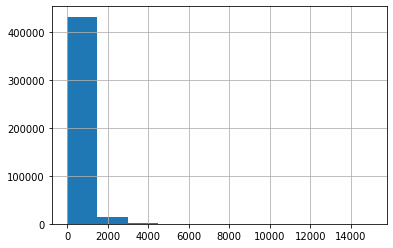

In [62]:
# histogram of all text lengths
clean_df['text'].str.len().hist()

In [63]:
# description of story texts
clean_df[clean_df['type'] == 'story']['text'].str.len().describe()

count     669.000000
mean      606.789238
std       697.342040
min         1.000000
25%       210.000000
50%       401.000000
75%       776.000000
max      7560.000000
Name: text, dtype: float64

In [64]:
# description of comment texts
clean_df[clean_df['type'] == 'comment']['text'].str.len().describe()

count    446952.000000
mean        423.729669
std         488.017941
min           1.000000
25%         144.000000
50%         276.000000
75%         523.000000
max       15018.000000
Name: text, dtype: float64

In [65]:
aux = clean_df[clean_df['type'] == 'comment']
aux2 = aux[aux['text'].str.len() <= 5]
aux2.head(10)

,text,by,timestamp,type,id,parent
1215,Like?,buboard,2019-11-06 16:43:36+00:00,comment,21464245,21464107.0
2909,Yes,rms,2009-06-08 08:45:09+00:00,comment,647012,646916.0
3212,yes,uptown,2012-01-25 16:45:35+00:00,comment,3510420,3510284.0
3495,We?,k__,2019-12-28 20:04:53+00:00,comment,21901381,21899269.0
4384,yeah,moron4hire,2013-07-30 22:42:19+00:00,comment,6130608,6130604.0
4927,-,sp332,2017-07-14 13:57:07+00:00,comment,14769793,14769632.0
5317,*sow,carapace,2018-06-09 00:59:10+00:00,comment,17270913,17270074.0
5658,Yes.,dredmorbius,2018-09-24 17:50:03+00:00,comment,18059742,18058193.0
5792,x264?,ZeroGravitas,2012-11-02 21:04:36+00:00,comment,4734742,4734499.0
6845,Done!,tptacek,2012-03-27 00:02:05+00:00,comment,3759257,3759201.0


In [66]:
aux2.shape

(507, 6)

In [67]:
aux2['text'].nunique()

235

In [69]:
#only 507 comments with 5 characters or less, upon analysis doesn't look like they provide much context, 
#not helpful for model analysis so drop comments with 5 words or less

# take only the rows whose text column's length is greater than five
# this also removes the texts that are None
clean_df = clean_df[clean_df['text'].str.len() > 5]

In [70]:
clean_df.head()

,text,by,timestamp,type,id,parent
0,No indication of how large these programs are ...,pjc50,2019-05-13 21:39:45+00:00,comment,19904253,19896542.0
1,"Well, if you want to obfuscate a constant stri...",thaumasiotes,2014-03-29 07:06:43+00:00,comment,7491659,7491605.0
2,"Yeah, it&#x27;s like how we had to stop using ...",coldtea,2017-06-19 18:22:17+00:00,comment,14589123,14588063.0
6,Well duh; would wouldn&#x27;t do X if X was af...,jodrellblank,2019-05-13 18:15:43+00:00,comment,19902101,19901310.0
7,What are the restrictions? Are you going to fi...,gus_massa,2018-12-06 19:27:51+00:00,comment,18621219,18620347.0


In [71]:
clean_df['text'].str.len().describe()

count    447356.000000
mean        424.291495
std         488.478961
min           6.000000
25%         144.000000
50%         277.000000
75%         523.000000
max       15018.000000
Name: text, dtype: float64

In [101]:
# Use BS on a single piece of text to remove strange chars and URLs and tags
from bs4 import BeautifulSoup

def clean_soup(text):
    # make a soup - this takes care of strange characters
    soup = BeautifulSoup(text, "html.parser")

    # delete <a> tags as they contain URLs -- remember <a href="url_here">
    # tags contain URLs
    for s in soup.select('a'):
       s.extract()

    # the soup contains <p> tags -- here we get rid of those and join them with spaces
    strings = soup.find_all(text=True, recursive=True)
    result = ' '.join(strings)

    return result

In [106]:
# Apply that to each comment/story text
clean_text = clean_df['text'].apply(clean_soup)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http:&#x2F;&#x2F;vimeo.com&#x2F;49718712" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https:&#x2F;&#x2F;arstechnica.com&#x2F;gaming&#x2F;2019&#x2F;08&#x2F;now-even-funerals-are-livestreamed-and-families-are-grateful&#x2F;" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https:&#x2F;&#x2F;www.youtube.com&#x2F;watch?v=uIlu7szab5I" looks like a URL. Beautiful Soup is not an HTTP client.

In [107]:
clean_df['text'] = clean_text

In [124]:
import pandas as pd
pd.options.display.max_colwidth = 100
clean_df.sample(10)

,text,by,timestamp,type,id,parent
150966,Dying is outside the scope of application. Please contact nearest heavenly body for ticket submi...,peterwwillis,2011-07-25 22:09:54+00:00,comment,2804949,2804860.0
445948,Any sources? These reports don't support your statements: And I don't know of a debt instrument...,lotsofpulp,2020-02-13 18:38:08+00:00,comment,22320141,22320063.0
48449,Inalienable doesn't mean what you seem to think it does.,dredmorbius,2016-04-13 07:55:38+00:00,comment,11486476,11486164.0
478518,Was just about to comment that in lieu of buying an ebook version of the currently discussed Uni...,danso,2019-10-28 14:10:19+00:00,comment,21377138,21373940.0
7279,"The former might be true, but it's very unlikely the latter, hard and harsh experience has shown...",hga,2014-06-19 15:19:48+00:00,comment,7916552,7915329.0
36698,That's known nowadays as AutoML. Google recently released AutoML products for image and text cla...,minimaxir,2018-08-27 16:26:39+00:00,comment,17852406,17852350.0
318870,"Sorry, what?",enraged_camel,2013-06-01 05:26:56+00:00,comment,5802846,5802806.0
421559,"Unemployment doesn't work that way. Otherwise, eg Singapore would have lots and lots of unemplo...",eru,2016-11-12 20:17:11+00:00,comment,12939944,12938454.0
369213,"True, but I imagine it is not far off from OP's area of work.",pjmlp,2017-02-10 19:26:10+00:00,comment,13618104,13616509.0
235943,I think they wanted to build a specific webapp as a way of learning what webapp developers need....,pg,2007-04-16 21:02:25+00:00,comment,13390,13388.0


In [125]:
#makes sense the parent would have some null values, if they are the first comment
clean_df.isnull().sum()

text           0
by             0
timestamp      0
type           0
id             0
parent       911
dtype: int64